In [19]:
import numpy as np
from pathlib import Path
from imageio.v3 import imread, imwrite
from skimage import img_as_ubyte
import tifffile
from cellpose import models, plot
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [20]:
data_path = Path("/Users/jack/Documents/one-cell")

nuclei_path = data_path / "nuclei.tif"
cyto_path = data_path / "cyto.tif"
pattern_path = data_path / "patterns.tif"

with tifffile.TiffFile(nuclei_path) as tif:
    nuclei = tif.pages[0].asarray()
with tifffile.TiffFile(cyto_path) as tif:
    cyto = tif.pages[0].asarray()
pattern = img_as_ubyte(imread(pattern_path))

In [21]:
def area(bbox):
    x1, y1, w, h = bbox
    return w * h

In [22]:
def adjust(bbox, height=0):
    x1, y1, w, h = bbox
    new_bbox = (x1, y1 + (h - height)//2, w, height)
    return new_bbox

In [23]:
def crop(image, bbox):
    x1, y1, w, h = bbox
    return image[y1:y1+h, x1:x1+w]

In [24]:
pattern_blur = cv2.GaussianBlur(pattern, (5, 5), 0)
_, pattern_binary = cv2.threshold(pattern_blur, 1, 255, cv2.THRESH_BINARY)
pattern_binary = cv2.morphologyEx(pattern_binary, cv2.MORPH_ERODE, np.ones((5, 5), np.uint8))
pattern_rgb = cv2.cvtColor(pattern_binary, cv2.COLOR_GRAY2RGB)
contours, _ = cv2.findContours(pattern_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
bbox = [cv2.boundingRect(c) for c in contours]
bbox = [b for b in bbox if area(b) > 1000]
bbox = [adjust(b, 30) for b in bbox]
pattern_rgb = cv2.cvtColor(pattern_binary, cv2.COLOR_GRAY2RGB)
# for b in bbox:
#     x1, y1, w, h = b
#     cv2.rectangle(pattern_rgb, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)
# plt.imshow(pattern_rgb)
# plt.show()

In [25]:
def normalize(image):
    image = img_as_ubyte(image)
    image_bg = cv2.medianBlur(image, 51)
    image_bg_blur = cv2.GaussianBlur(image_bg, (0, 0), sigmaX=101, sigmaY=101)
    image_clean = cv2.subtract(image, image_bg_blur)
    p1 = np.percentile(image_clean[image_clean > 0], 1)
    p99 = np.percentile(image_clean[image_clean > 0], 99)
    image = (image_clean - p1) / (p99 - p1)
    image = image.clip(0, 1)
    image = image * 255
    return image.astype(np.uint8)

In [26]:
def normalize_simple(image):
    image = img_as_ubyte(image)
    min = np.min(image)
    max = np.max(image)
    image = (image - min) / (max - min)
    image = image * 255
    return image.astype(np.uint8)

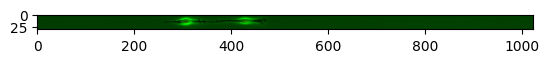

In [27]:
overlay_rgb = np.zeros((*pattern_rgb.shape[:2], 3), dtype=np.uint8)
overlay_rgb[..., 0] = img_as_ubyte(nuclei)
overlay_rgb[..., 1] = img_as_ubyte(cyto)
crop_rgb = crop(overlay_rgb, bbox[0])
imwrite("crop_rgb.png", crop_rgb)
plt.imshow(crop_rgb)
plt.show()

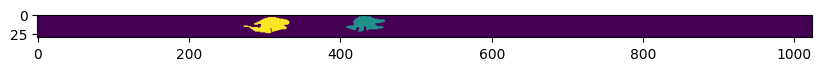

In [28]:
model = models.Cellpose(gpu=True, model_type='cyto3')
masks, flows, styles, diams = model.eval(crop_rgb, diameter=None, channels=[2, 1])
fig = plt.figure(figsize=(10, 10))
plt.imshow(masks)
plt.show()


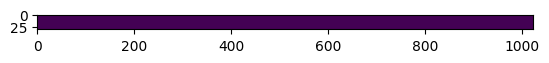

In [29]:
model = models.Cellpose(gpu=True, model_type='cyto3')
masks, flows, styles, diams = model.eval(crop(img_as_ubyte(nuclei)*255, bbox[0]), channels=[0, 0])
plt.imshow(masks)
plt.show()